# Validation tests for Sprinkler

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update(mpl.rcParamsDefault)
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['font.serif'] = ['times new roman']
# mpl.rcParams['font.sans-serif'] =  ['times', 'times new roman'] 
mpl.use('Agg')

import numpy as np
import astropy.io.fits as pyfits
import pandas as pd
import om10
import seaborn as sns
# sns.set(context='notebook', style='darkgrid', palette='deep', font='serif', font_scale=2, color_codes=True)
sns.set(palette='deep', font='DejaVu Sans', font_scale=2, color_codes=True)

om10.DB: selection yields  1000  lenses


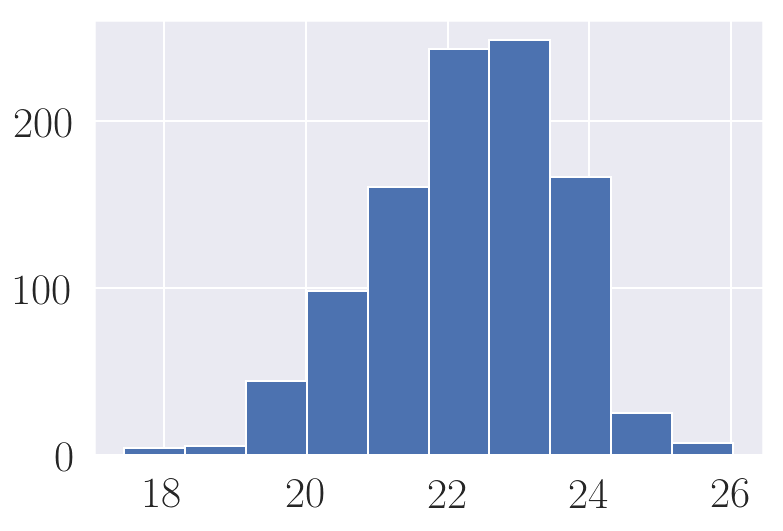

In [2]:
db = om10.DB("./data/qso_mock.fits")
#     db.select_random(maglim=99.0,area=18000.0,IQ=0.7)
db.select_random(Nlens=1000)
good = db.sample

plt.hist(good['MAGI_IN']);

In [3]:
#-----------------------
# Sprinkler
#


def create_cats_agns(index, hdu_list, ahb_list, ahd_list):
    try:
        twinkles_ID = ahd_list['twinkles_system'][index]
    except:
        return 0, 0, 0
   
    bad = hdu_list[1].data
    idx = hdu_list[1].data['twinklesId'] == twinkles_ID
       
    zlens = bad['ZLENS'][idx][0]
    zsrcs = bad['ZSRC'][idx][0]
    tdmax = np.log10(np.max(bad['DELAY'][idx][0])) #log10(days)
    spmax = bad['IMSEP'][idx][0]
    apmdi = bad['APMAG_I'][idx][0]
    apmsi = bad['MAGI_IN'][idx][0]
    apmli = bad['MAGI_IN'][idx][0] - 2.5*np.log10(np.sum(np.abs(bad['MAG'][idx][0])))
    Datasets= 'The BAD (Sprinkler)'
    #----------------------------------------------------------------------------
    lens_cat = {'zlens'      : zlens,
                'zsrcs'      : zsrcs,
                'tdmax'      : tdmax,
                'spmax'      : spmax,
                'apmdi'      : apmdi,
                'apmsi'      : apmsi,
                'apmli'      : apmli,
                'Datasets'   : Datasets}
    #----------------------------------------------------------------------------
    return lens_cat


def load_in_Sprinkler():    
    agn_host_bulge = pd.read_csv("./data/cosmoDC2_v1.0_bulge_agn_host.csv")
    agn_host_disk = pd.read_csv("./data/cosmoDC2_v1.0_disk_agn_host.csv")    
    idx = agn_host_bulge['image_number'] == 0
    ahb_purged = agn_host_bulge[:][idx]
    ahd_purged = agn_host_disk[:][idx]
    lens_list = pyfits.open("./data/cosmoDC2_v1.0_matched_AGN.fits")

    nlenses = len(ahd_purged.index)

    data_sprinkler = {}
    data_sprinkler['zlens'] = np.zeros(nlenses)
    data_sprinkler['zsrcs'] = np.zeros(nlenses)
    data_sprinkler['tdmax'] = np.zeros(nlenses)
    data_sprinkler['spmax'] = np.zeros(nlenses)
    data_sprinkler['apmdi'] = np.zeros(nlenses)
    data_sprinkler['apmsi'] = np.zeros(nlenses)
    data_sprinkler['apmli'] = np.zeros(nlenses)
    data_sprinkler['Datasets']= np.zeros(nlenses, dtype='S256')

    for i in xrange(nlenses):
        lensP = create_cats_agns(ahb_purged.index[i], lens_list, ahb_purged, ahd_purged)
        if lensP == 0:
            continue
        else:
            data_sprinkler['zlens'][i] = lensP['zlens']
            data_sprinkler['zsrcs'][i] = lensP['zsrcs']
            data_sprinkler['tdmax'][i] = lensP['tdmax']
            data_sprinkler['spmax'][i] = lensP['spmax']
            data_sprinkler['apmdi'][i] = lensP['apmdi']
            data_sprinkler['apmsi'][i] = lensP['apmsi']
            data_sprinkler['apmli'][i] = lensP['apmli']
            data_sprinkler['Datasets'][i]= lensP['Datasets']

    df_sprinkler = pd.DataFrame(data=data_sprinkler)
    return df_sprinkler

In [8]:
#-----------------------
# OM10
#

def load_in_OM10():
    db = om10.DB("./data/qso_mock.fits")
    db.select_random(maglim=99.0,area=18000.0,IQ=0.7)
#     db.select_random(Nlens=1000)
#     good = db.sample

#     good = db.sample[np.where(\
#             (db.sample['IMSEP'] > 0.0) *\
#             (db.sample['IMSEP'] > 0.0) * \
#             (db.sample['APMAG_I'] < 99.0) * \
#             (np.max(db.sample['DELAY'],axis=1) > 0.0))]
        
    good = db.sample[np.where(db.sample['ZSRC'] < 3.0)]
    print "Number in cosmography sub-sample:",len(good)

    #[z_d, z_s, dt_max, imsep_max, i_AGN, i_d]

    data_om10 = {}
    data_om10['zlens'] = good['ZLENS']
    data_om10['zsrcs'] = good['ZSRC']
    data_om10['tdmax'] = np.log10(np.max(good['DELAY'], axis=1)) #/30.0 #month
    data_om10['spmax'] = good['IMSEP']
    data_om10['apmdi'] = good['APMAG_I']
    data_om10['apmsi'] = good['MAGI_IN']
    data_om10['apmli'] = good['MAGI_IN'] - 2.5*np.log10(np.sum(np.abs(good['MAG']), axis=1))
    data_om10['Datasets'] = 'The GOOD (OM10)'

    df_om10 = pd.DataFrame(data=data_om10)
    return df_om10

In [9]:
#-----------------------
# MatchedAGNs
#

def load_in_MatchedAGNs():
    ugly = pyfits.getdata("./data/cosmoDC2_v1.0_matched_AGN.fits")
#     ugly = pyfits.getdata("./data/cosmoDC2_v1.0_matched_AGN_mag_weighted.fits")

    data_MatchedAGNs = {}
    data_MatchedAGNs['zlens'] = ugly['ZLENS']
    data_MatchedAGNs['zsrcs'] = ugly['ZSRC']
    data_MatchedAGNs['tdmax'] = np.log10(np.max(ugly['DELAY'], axis=1)) #/30.0 #month
    data_MatchedAGNs['spmax'] = ugly['IMSEP']
    data_MatchedAGNs['apmdi'] = ugly['APMAG_I']
    data_MatchedAGNs['apmsi'] = ugly['MAGI_IN']
    data_MatchedAGNs['apmli'] = ugly['MAGI_IN'] - 2.5*np.log10(np.sum(np.abs(ugly['MAG']), axis=1))
    data_MatchedAGNs['Datasets'] = 'The UGLY (MatchedAGNs)'

    df_MatchedAGNs = pd.DataFrame(data=data_MatchedAGNs)
    return df_MatchedAGNs

In [10]:
def load_in_NewMatchedAGNs():
#     ugly = pyfits.getdata("./data/cosmoDC2_v1.0_matched_AGN.fits")
    ugly = pyfits.getdata("./data/cosmoDC2_v1.0_matched_AGN_mag_weighted.fits")

    data_NewMatchedAGNs = {}
    data_NewMatchedAGNs['zlens'] = ugly['ZLENS']
    data_NewMatchedAGNs['zsrcs'] = ugly['ZSRC']
    data_NewMatchedAGNs['tdmax'] = np.log10(np.max(ugly['DELAY'], axis=1)) #/30.0 #month
    data_NewMatchedAGNs['spmax'] = ugly['IMSEP']
    data_NewMatchedAGNs['apmdi'] = ugly['APMAG_I']
    data_NewMatchedAGNs['apmsi'] = ugly['MAGI_IN']
    data_NewMatchedAGNs['apmli'] = ugly['MAGI_IN'] - 2.5*np.log10(np.sum(np.abs(ugly['MAG']), axis=1))
    data_NewMatchedAGNs['Datasets'] = 'The PRETTY (NewMatchedAGNs)'

    df_NewMatchedAGNs = pd.DataFrame(data=data_NewMatchedAGNs)
    return df_NewMatchedAGNs

In [11]:
dataf_good   = load_in_OM10()
dataf_bad    = load_in_Sprinkler()
dataf_ugly   = load_in_MatchedAGNs()
dataf_pretty = load_in_NewMatchedAGNs()

om10.DB: selection yields  2818  lenses
Number in cosmography sub-sample: 2103


/Users/uranus/Applications/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [12]:
frames = [dataf_good, dataf_bad, dataf_ugly, dataf_pretty]
result = pd.concat(frames)

/Users/uranus/Applications/miniconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


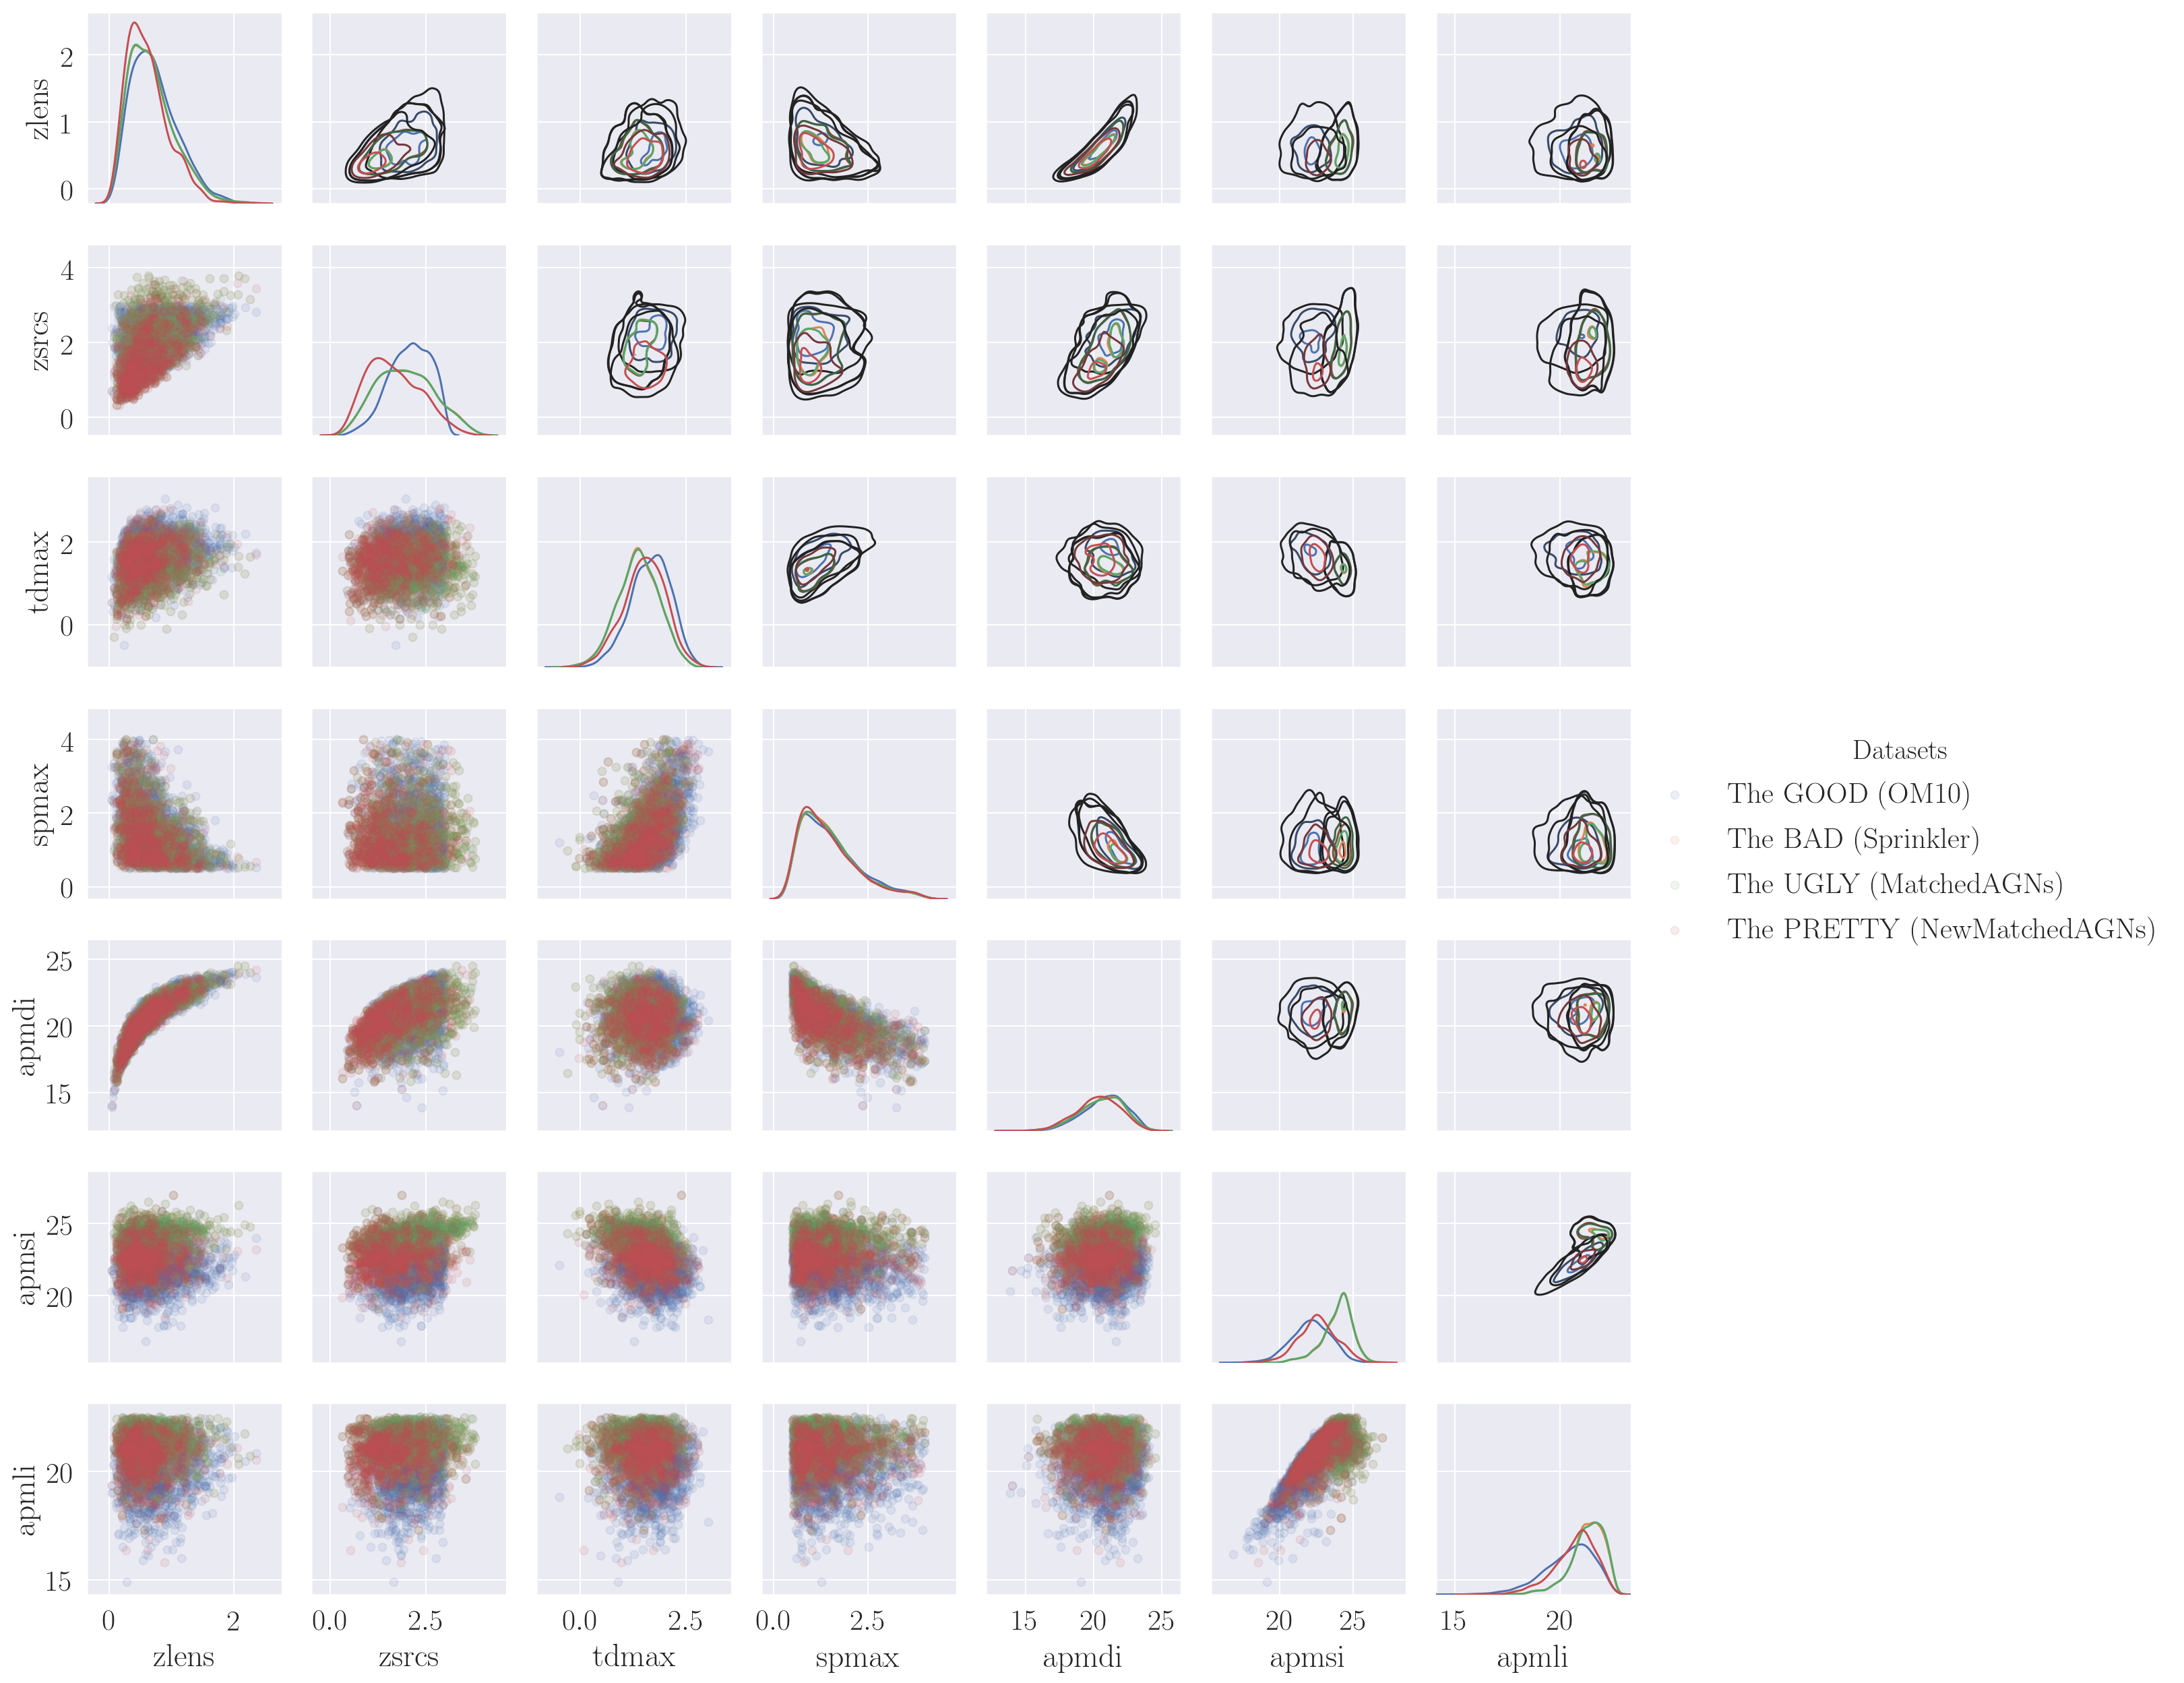

In [13]:
pg = sns.PairGrid(result, vars=('zlens', 'zsrcs', 'tdmax', 'spmax', 'apmdi', 'apmsi', 'apmli'), hue='Datasets')
pg.map_diag(sns.kdeplot)
pg.map_upper(sns.kdeplot, n_levels=3)
pg.map_lower(plt.scatter, alpha=0.1)
pg.add_legend();

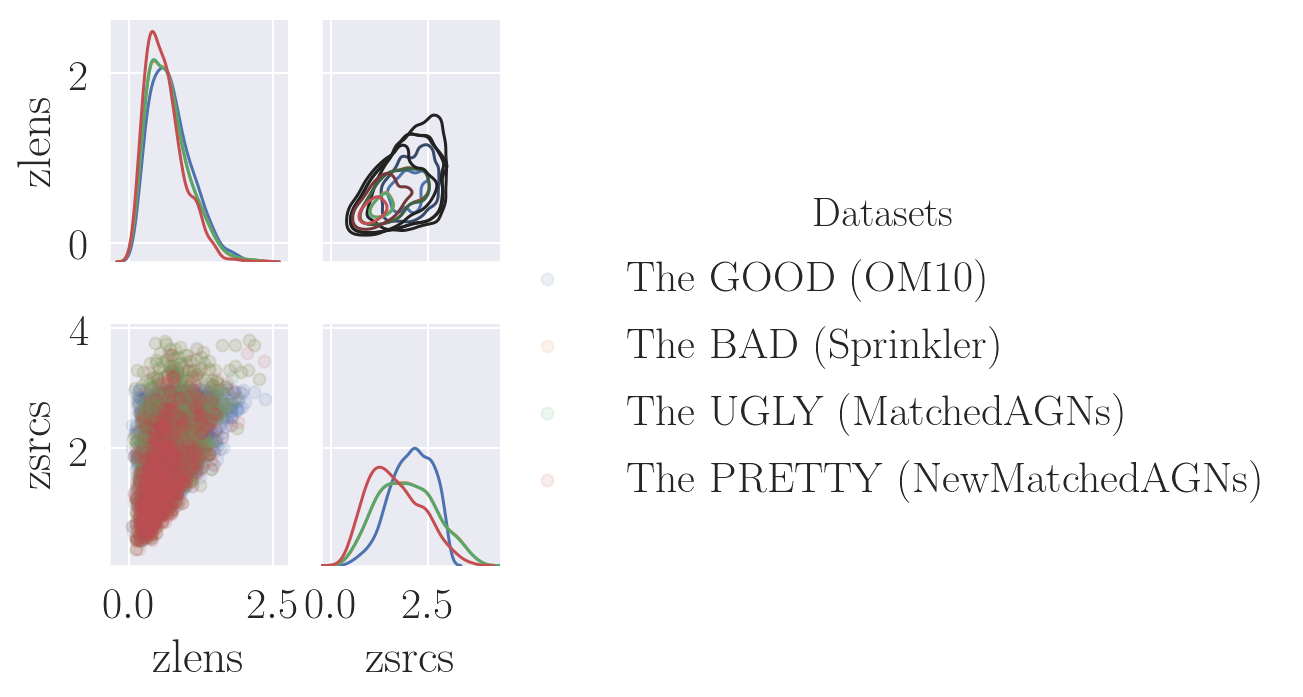

In [14]:
frames = [dataf_good, dataf_bad, dataf_ugly, dataf_pretty]
result = pd.concat(frames)

pg = sns.PairGrid(result, vars=('zlens', 'zsrcs'), hue='Datasets')
pg.map_diag(sns.kdeplot)
pg.map_upper(sns.kdeplot, n_levels=3)
pg.map_lower(plt.scatter, alpha=0.1)
pg.add_legend();

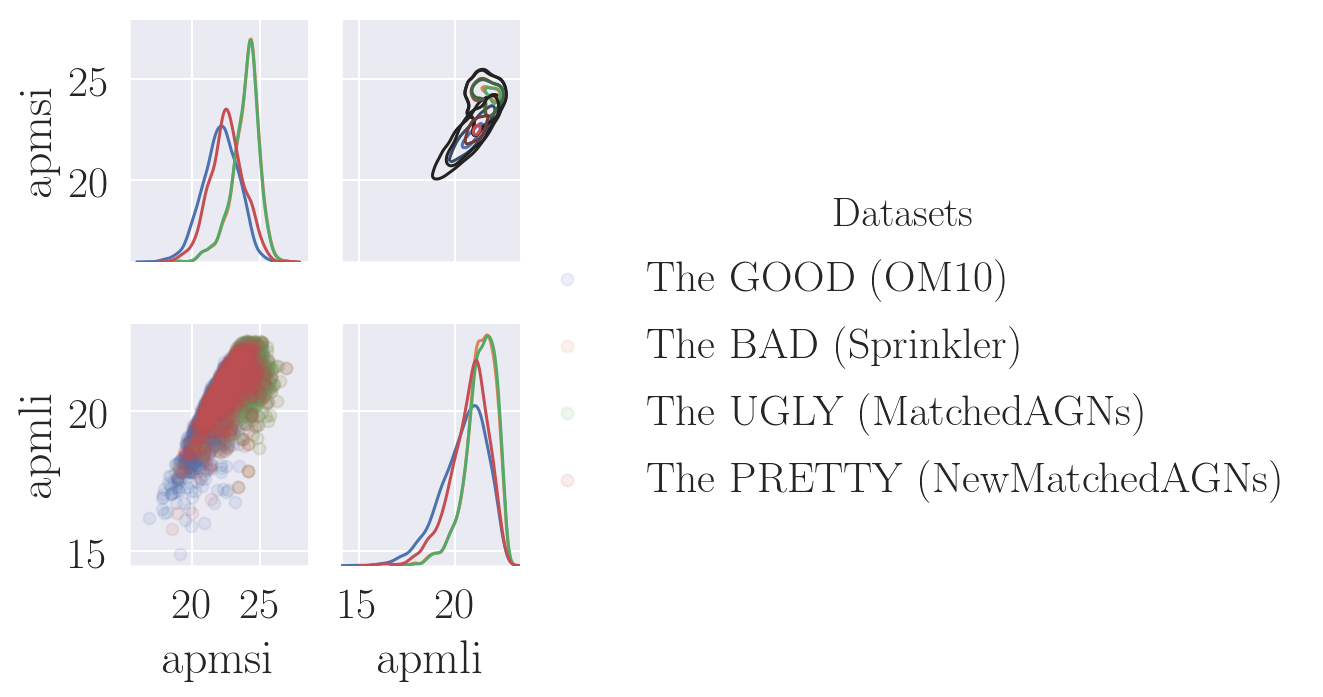

In [15]:
pg = sns.PairGrid(result, vars=('apmsi', 'apmli'), hue='Datasets')
pg.map_diag(sns.kdeplot)
pg.map_upper(sns.kdeplot, n_levels=3)
pg.map_lower(plt.scatter, alpha=0.1)
pg.add_legend();